In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
n_split = 5

In [3]:
import pickle
import numpy as np

In [4]:
with open('/content/drive/My Drive/Data Master/X_train_final', 'rb') as file:
    X_train_valid = pickle.load(file)

with open('/content/drive/My Drive/Data Master/Y_train_final', 'rb') as file:
    Y_train_valid = pickle.load(file)

with open('/content/drive/My Drive/Data Master/word_index_final', 'rb') as file:
    word_index = pickle.load(file)

with open('/content/drive/My Drive/Data Master/train_index_final_split_' + str(n_split), 'rb') as file:
    train_index = pickle.load(file)

with open('/content/drive/My Drive/Data Master/valid_index_final_split_' + str(n_split), 'rb') as file:
    valid_index = pickle.load(file)

In [5]:
X_train = list(np.array(X_train_valid)[train_index])
X_valid = list(np.array(X_train_valid)[valid_index])
Y_train = list(np.array(Y_train_valid)[train_index])
Y_valid = list(np.array(Y_train_valid)[valid_index])

In [6]:
inv_word_index = {ix : w for w, ix in word_index.items()}

In [7]:
!pip install transformers

In [8]:
import pandas as pd
import numpy as np
import itertools

import torch
import torch.nn as nn
import transformers
import torch.utils.data as tdata
import torch.optim as optim

import tqdm

In [9]:
from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
bert_tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
#bert_model = BertForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased').to(device)
bert_model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [12]:
def get_text_head(sent, head_size = 500):
  res = []
  res.append(sent[:head_size])
  return res

def get_text_tail(sent, tail_size = 500):
  res = []
  res.append(sent[-tail_size:])
  return res

In [13]:
data_train_chunked_head = [(i, get_text_head([inv_word_index[ix] for ix in X_train[i]]), Y_train[i]) for i, d in enumerate(X_train)]
data_valid_chunked_head = [(i, get_text_head([inv_word_index[ix] for ix in X_valid[i]]), Y_valid[i]) for i, d in enumerate(X_valid)]

data_train_chunked_tail = [(i, get_text_tail([inv_word_index[ix] for ix in X_train[i]]), Y_train[i]) for i, d in enumerate(X_train)]
data_valid_chunked_tail = [(i, get_text_tail([inv_word_index[ix] for ix in X_valid[i]]), Y_valid[i]) for i, d in enumerate(X_valid)]

In [14]:
data_train_chunked_splitted_head = [(i, [" ".join(subsent) for subsent in chunked_sent], y) for i, chunked_sent, y in data_train_chunked_head]
data_valid_chunked_splitted_head = [(i, [" ".join(subsent) for subsent in chunked_sent], y) for i, chunked_sent, y in data_valid_chunked_head]

data_train_chunked_splitted_tail = [(i, [" ".join(subsent) for subsent in chunked_sent], y) for i, chunked_sent, y in data_train_chunked_tail]
data_valid_chunked_splitted_tail = [(i, [" ".join(subsent) for subsent in chunked_sent], y) for i, chunked_sent, y in data_valid_chunked_tail]

In [15]:
df_train_chunked_splitted_head = pd.DataFrame(
    list(itertools.chain.from_iterable([[[doc, c, y] for c in chunks] for doc, chunks, y in data_train_chunked_splitted_head])),
    columns=['doc', 'chunk', 'FgOrdinario'])

df_valid_chunked_splitted_head = pd.DataFrame(
    list(itertools.chain.from_iterable([[[doc, c, y] for c in chunks] for doc, chunks, y in data_valid_chunked_splitted_head])),
    columns=['doc', 'chunk', 'FgOrdinario'])

df_train_chunked_splitted_tail = pd.DataFrame(
    list(itertools.chain.from_iterable([[[doc, c, y] for c in chunks] for doc, chunks, y in data_train_chunked_splitted_tail])),
    columns=['doc', 'chunk', 'FgOrdinario'])

df_valid_chunked_splitted_tail = pd.DataFrame(
    list(itertools.chain.from_iterable([[[doc, c, y] for c in chunks] for doc, chunks, y in data_valid_chunked_splitted_tail])),
    columns=['doc', 'chunk', 'FgOrdinario'])

In [16]:
sentences_train_head = df_train_chunked_splitted_head.chunk.values
sentences_train_tail = df_train_chunked_splitted_tail.chunk.values
labels_train = df_train_chunked_splitted_head.FgOrdinario.values

sentences_valid_head = df_valid_chunked_splitted_head.chunk.values
sentences_valid_tail = df_valid_chunked_splitted_tail.chunk.values
labels_valid = df_valid_chunked_splitted_head.FgOrdinario.values

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train_head = []
attention_masks_train_head = []

# For every sentence...
for sent in tqdm.notebook.tqdm(sentences_train_head):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train_head.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train_head.append(encoded_dict['attention_mask'])

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train_tail = []
attention_masks_train_tail = []

# For every sentence...
for sent in tqdm.notebook.tqdm(sentences_train_tail):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_train_tail.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_train_tail.append(encoded_dict['attention_mask'])

In [19]:
input_ids_train = torch.cat([torch.cat([h[:,:128], t[:,-384:]], dim=1) for h, t in zip(input_ids_train_head, input_ids_train_tail)])
attention_masks_train = torch.cat([torch.cat([h[:,:128], t[:,-384:]], dim=1) for h, t in zip(attention_masks_train_head, attention_masks_train_tail)])
labels_train = torch.tensor(labels_train)

In [20]:
input_ids_train.shape

torch.Size([712, 512])

In [21]:
attention_masks_train.shape

torch.Size([712, 512])

In [22]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_train_head[10], sentences_train_tail[10])
print('Token IDs:', input_ids_train[10])

Original:  ao conselho administrativo de defesa económica  cade superintendéncia geral do cade  sg m dias branco s a indústria e comercio de alimentos 'mdb ou compradora sociedade anônima de capital aberto inscrita no cadastro nacional da pessoa jurídica cnpj mf sob nº 07 206 816 0001 15 com sede em jabuti estado no ceará na rodovia br116 km 18 cep º 61 760 000 e indústria de produtos alimentícios piraquê s a piraquê ou vendedora e seus acionistas sociedade anônima de capital fechado com sede na cidade do rio de janeiro estado do rio de janeiro na rua leopoldino de oliveira 335 turiaçu cep nº 21360060 conjuntamente requerentes por meio de seus advogados que estas subscrevem vêm respeitosamente nos termos do artigo 88 da lei nº 12 529 2011 e da resolução cade nº 01 2012 anexo i e resolução 02 2012 anexo ii submeter ao conselho administrativo de defesa econômica cade o presente ato de concentração económica consubstanciado no contrato de compra e venda de ações e outras

In [23]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_valid_head = []
attention_masks_valid_head = []

# For every sentence...
for sent in tqdm.notebook.tqdm(sentences_valid_head):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid_head.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid_head.append(encoded_dict['attention_mask'])

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_valid_tail = []
attention_masks_valid_tail = []

# For every sentence...
for sent in tqdm.notebook.tqdm(sentences_valid_tail):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_valid_tail.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_valid_tail.append(encoded_dict['attention_mask'])

In [25]:
input_ids_valid = torch.cat([torch.cat([h[:,:128], t[:,-384:]], dim=1) for h, t in zip(input_ids_valid_head, input_ids_valid_tail)])
attention_masks_valid = torch.cat([torch.cat([h[:,:128], t[:,-384:]], dim=1) for h, t in zip(attention_masks_valid_head, attention_masks_valid_tail)])
labels_valid = torch.tensor(labels_valid)

In [26]:
input_ids_valid.shape

torch.Size([176, 512])

In [27]:
attention_masks_valid.shape

torch.Size([176, 512])

In [28]:
print('Original: ', sentences_valid_head[10], sentences_valid_tail[10])
print('Token IDs:', input_ids_valid[10])

Original:  stocche forbes ilustríssimo senhor eduardo frade rodrigues superintendente geral do conselho administrativo de defesa económica cade brazil steel investimentos e participaçóes s a brazil steel sociedade por ações de capital fechado devidamente constituída e existente de acordo com as 3 i ' 5 leis da república federativa do brasil com sede na cidade de são paulo estado de são paulo º na avenida cidade jardim nº 803 9º andar sala c cep 01453 000 inscrita no cnpj mf sob 0 número 20 512 148 0001 12 dánica termoindustrial brasil s a dánica brasil 'é sociedade por ações de capital fechado devidamente constituída e existente de acordo com asªs leis da república f ederativa do brasil com sede na cidade de joinville estado de santa catatinaãã na rua noruega nº 99 boa vista inscrita no cnpj mf sob o número 42 506 618 0001 78 e zípco sistemas construtivos s a zipco sociedade por ações de capital fechadofiíª r devidamente constituída e existente de acordo com as lels da repubhca f

In [29]:
from torch.utils.data import TensorDataset

In [30]:
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
valid_dataset = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 6

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [32]:
from transformers import AdamW, BertConfig

# Tell pytorch to run this model on the GPU.
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(bert_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [35]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
del data_train_chunked_head
del data_valid_chunked_head
del data_train_chunked_tail
del data_valid_chunked_tail
del data_train_chunked_splitted_head
del data_valid_chunked_splitted_head
del data_train_chunked_splitted_tail
del data_valid_chunked_splitted_tail

del input_ids_valid_head
del input_ids_valid_tail

del attention_masks_train_head
del attention_masks_valid_tail

In [38]:
import gc
gc.collect()

333

In [39]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bert_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        bert_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    119.    Elapsed: 0:00:29.
  Batch    80  of    119.    Elapsed: 0:00:59.

  Average training loss: 0.47
  Training epcoh took: 0:01:28

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.49
  Validation took: 0:00:07

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    119.    Elapsed: 0:00:30.
  Batch    80  of    119.    Elapsed: 0:01:00.

  Average training loss: 0.40
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.53
  Validation took: 0:00:07

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    119.    Elapsed: 0:00:30.
  Batch    80  of    119.    Elapsed: 0:01:00.

  Average training loss: 0.28
  Training epcoh took: 0:01:30

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.44
  Validation took: 0:00:07

Training complete!
Total training took 0:04:48 (h:mm:ss)


In [40]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.47,0.49,0.81,0:01:28,0:00:07
2,0.40,0.53,0.81,0:01:30,0:00:07
3,0.28,0.44,0.87,0:01:30,0:00:07


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


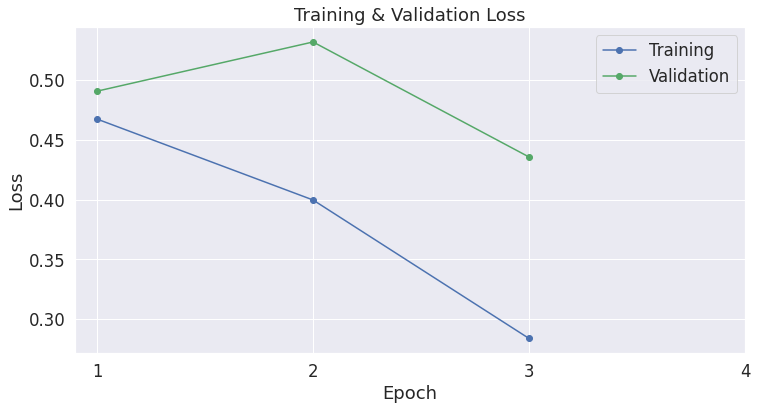

In [41]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [42]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/Colab Notebooks/Torch/_FineTuningModels/SentenceClassification/model_save/bert_model_sentence_classification_tail_tuned_split_' + str(n_split) + '/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
bert_tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/My Drive/Colab Notebooks/Torch/_FineTuningModels/SentenceClassification/model_save/bert_model_sentence_classification_tail_tuned_split_5/


('/content/drive/My Drive/Colab Notebooks/Torch/_FineTuningModels/SentenceClassification/model_save/bert_model_sentence_classification_tail_tuned_split_5/vocab.txt',
 '/content/drive/My Drive/Colab Notebooks/Torch/_FineTuningModels/SentenceClassification/model_save/bert_model_sentence_classification_tail_tuned_split_5/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/Torch/_FineTuningModels/SentenceClassification/model_save/bert_model_sentence_classification_tail_tuned_split_5/added_tokens.json')